# Tensorflow 2 MNIST example

This is simple example of training model on MNIST dataset. Dataset provided by [*tensorflow_datasets*](https://www.tensorflow.org/datasets/api_docs/python/tfds) package. For running this example on local machine you can use the following Dockerfile:


    FROM tensorflow/tensorflow:2.0.0b1-gpu-py3

    RUN apt update && \

        apt upgrade -y && \

        apt install -y curl python3-pip libsm6 libxext6 libxrender-dev

    RUN curl -sL https://deb.nodesource.com/setup_10.x | bash -

    RUN apt install -y nodejs

    RUN pip3 install jupyterlab matplotlib opencv-python numpy pandas tensorflow_datasets ipywidgets

    RUN jupyter labextension install jupyterlab_vim

    RUN jupyter labextension install @jupyterlab/toc

    RUN jupyter nbextension install --py --sys-prefix widgetsnbextension

    RUN jupyter labextension install @jupyter-widgets/jupyterlab-manager

    CMD jupyter-lab --ip 0.0.0.0 --port 8888 --allow-root_

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import tqdm
import matplotlib.pyplot as plt

tf.__version__

'2.0.0-beta1'

## Use GPU resources as needed

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load dataset

[*tensorflow_datasets*](https://www.tensorflow.org/datasets/api_docs/python/tfds) provides many dataset. Let's download MNIST

In [3]:
train_mnist = tfds.load(name='mnist', split=tfds.Split.TRAIN, with_info=True)
test_mnist = tfds.load(name='mnist', split=tfds.Split.TEST, with_info=True)

W0821 19:57:36.736060 140342909093696 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


We have specified parameter _with_info=True_. So, the second elemet of tuple is object that describe dataset. Let's extract samples count

In [4]:
test_examples = train_mnist[1].splits['test'].num_examples
train_examples = train_mnist[1].splits['train'].num_examples

## Prepare iterable dataset

In [5]:
batch_size = 32
dataset_train = train_mnist[0].shuffle(train_examples).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
dataset_test = test_mnist[0].shuffle(test_examples).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## Define model using subclassing keras API

In [6]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.cnv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=tf.keras.activations.selu)
        self.cnv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=tf.keras.activations.selu)
        
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        
        self.flat = tf.keras.layers.Flatten()
        
        self.fc1 = tf.keras.layers.Dense(units=128, activation=tf.keras.activations.softmax)
        self.fc2 = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)
        
        self.dp1 = tf.keras.layers.Dropout(0.25)
        self.dp2 = tf.keras.layers.Dropout(0.5)
        
    def call(self, inputs, training=False):
        x = inputs
        x = self.cnv1(x)
        x = self.cnv2(x)
        x = self.pool(x)
        if training:
            x = self.dp1(x)
        x = self.flat(x)
        if training:
            x = self.dp2(x)
        x = self.fc2(x)
        
        return x

## Loss & accuracy utils

Decorator _@tf.function_ converts ordinary python function to computational graph

In [7]:
@tf.function
def compute_loss(logits, labels):
    loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    )
    return loss

@tf.function
def compute_accuracy(logits, labels):
    pred = tf.argmax(logits, axis=1)
    acc = tf.reduce_mean(tf.cast(tf.equal(pred, labels), tf.float32))
    return acc

## Train step

In [8]:
@tf.function
def train_one_step(model, opt, x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss = compute_loss(logits=logits, labels=y)
        
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    acc = compute_accuracy(logits, y)
    
    return loss, acc

## Test step

In [9]:
@tf.function
def test_one_step(model, x, y):
    logits = model(x)
    loss = compute_loss(logits=logits, labels=y)
    acc = compute_accuracy(logits, y)
    
    return loss, acc

## Create model

In [10]:
model = Model()
model.build(input_shape=(32, 28, 28, 1))

W0821 19:57:37.457150 140342909093696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:4149: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Train one epoch

In [11]:
message = '{} | Loss: {:0.4f} Acc: {:0.2f}'

def train_epoch(model, optimizer, train_set):
    avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
    avg_acc = tf.keras.metrics.Mean('acc', dtype=tf.float32)
    dataset_with_progress = tqdm.tqdm_notebook(train_set, total=train_examples//batch_size)
    for f in dataset_with_progress:
        x = f['image']/255
        x = tf.cast(x, tf.float32)


        loss, acc =  train_one_step(model, optimizer, x, f['label'])
        avg_loss(loss)
        avg_acc(acc)
        dataset_with_progress.set_description(message.format('Train', avg_loss.result().numpy(), avg_acc.result().numpy()))
    return avg_loss, avg_acc


def test_epoch(model, test_set):
    avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
    avg_acc = tf.keras.metrics.Mean('acc', dtype=tf.float32)
    dataset_with_progress = tqdm.tqdm_notebook(test_set, total=test_examples//batch_size)
    for f in dataset_with_progress:
        x = f['image']/255
        x = tf.cast(x, tf.float32)


        loss, acc = test_one_step(model, x, f['label'])
        avg_loss(loss)
        avg_acc(acc)
        dataset_with_progress.set_description(message.format('Test', avg_loss.result().numpy(), avg_acc.result().numpy()))
    return avg_loss, avg_acc

## Train model

In [12]:
epochs = 100

opt = tf.keras.optimizers.Adam()

log = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
for e in tqdm.tqdm_notebook(range(epochs)):
    train_loss, train_acc = train_epoch(model, opt, dataset_train)
    test_loss, test_acc = test_epoch(model, dataset_test)
    
    log['train_loss'].append(train_loss.result().numpy())
    log['train_acc'].append(train_acc.result().numpy())
    log['test_loss'].append(test_loss.result().numpy())
    log['test_acc'].append(test_acc.result().numpy())

## Plot training log

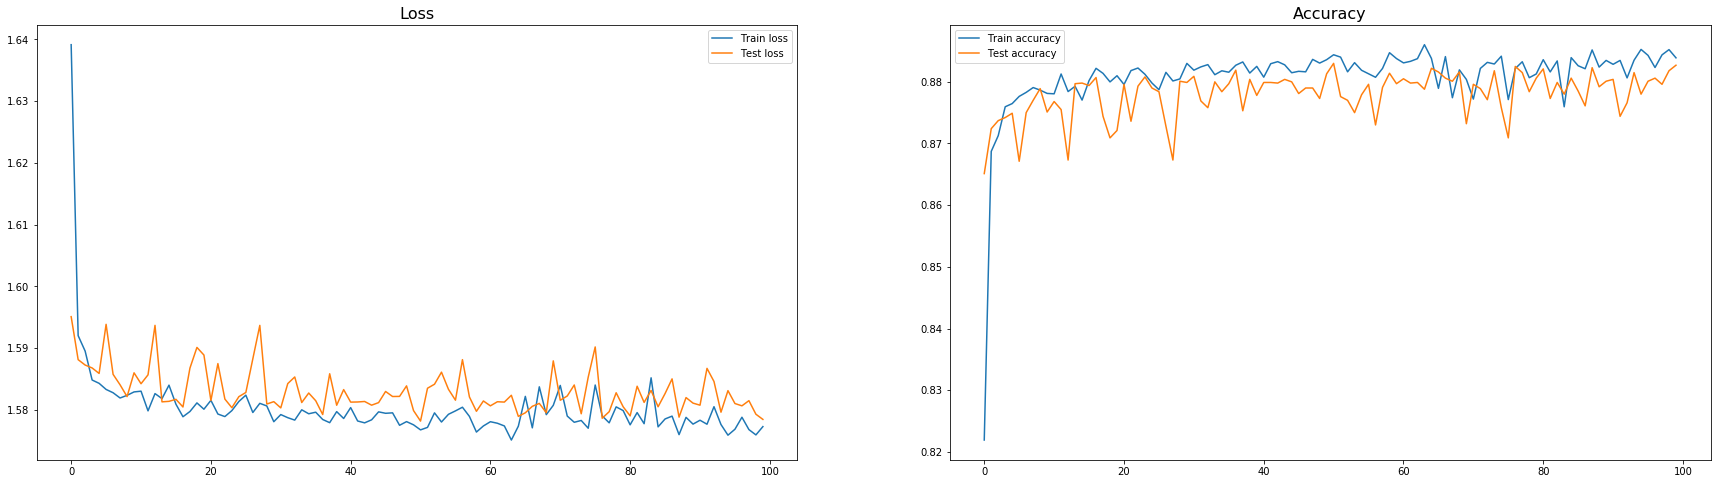

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(30, 8))
ax[0].set_title('Loss', fontsize=16)
ax[0].plot(range(epochs), log['train_loss'], label='Train loss')
ax[0].plot(range(epochs), log['test_loss'], label='Test loss')
ax[0].legend()

ax[1].set_title('Accuracy', fontsize=16)
ax[1].plot(range(epochs), log['train_acc'], label='Train accuracy')
ax[1].plot(range(epochs), log['test_acc'], label='Test accuracy')
ax[1].legend();